# MUSC incremental integrity

Initial *internal* requirements stated that each batch of incremental files from MUSC would be self-contained such that every referenced visit and patient would exist in the batch's visit and patient files, even if the values of visit and patient data elements did not change.  If this were required, then we would never violate global relational integrity -- i.e., the requirement that each referenced visit and patient exists in the total body of data.

In these notes, I aim to quantify, particularly for visits, intra-batch integrity violations *and* to separate global integrity violations.

In [1]:
import getpass
import pandas as pd

from sqlalchemy import create_engine

import edatls.crosstabular as crosstabular
import edatls.cryptic as cryptic
import edatls.tabular as tabular

oracle_connection_string = 'oracle+cx_oracle://' + \
    '{username}:{password}@{hostname}:{port}/{database}'

engine = create_engine(
    oracle_connection_string.format(
        username=input('User: '),
        password=getpass.getpass('Password: '),
        hostname='hssc-cdwr3-dtdb-p',
        port='1521',
        database='dtprd2'
    ),
    arraysize=50000
)

User: ephelps
Password: ········


## Get distinct visit numbers from CDW

In [2]:
def get_cdw_vnums(fn_vnums='vnums_musc.csv.gz'):
    df = None
    try:
        df = pd.read_csv(fn_vnums, compression='infer') #, dtype=str)
    except FileNotFoundError as e:
        print('File %s not found.'%fn_vnums)
        # the date criteria was added after knowledge of the batches at hand
        sql_vnums = '''
            select /*+ parallel 4 */
              enc.htb_enc_id_ext, enc.htb_enc_act_id,
              enc.visit_start_date, enc.visit_end_date,
              enc.class_code, enc.type_code,
              case when coalesce(dx.n_pdx, 0) > 0 then 1 else 0 end has_pdx,
              case when coalesce(dx.n_dxs, 0) > 0 then 1 else 0 end has_dxs,
              case when coalesce(px.n_pxs, 0) > 0 then 1 else 0 end has_pxs,
              case when coalesce(mo.n_mos, 0) > 0 then 1 else 0 end has_mos,
              case when coalesce(lr.n_lrs, 0) > 0 then 1 else 0 end has_lrs,
              case when coalesce(obs.n_obs, 0) > 0 then 1 else 0 end has_obs
            from cdw.visit enc
            left outer join (
              select
                visit_id,
                count(case when pdx = 'P' then 1 else NULL end) n_pdx,
                count(distinct dx_code) n_dxs_uniq,
                count(dx_code) n_dxs
              from cdw.diagnosis
              group by visit_id
            ) dx on ( enc.visit_id = dx.visit_id )
            left outer join (
              select
                visit_id,
                count(distinct proc_code) n_pxs_uniq,
                count(proc_code) n_pxs
              from cdw.procedure
              group by visit_id
            ) px on ( enc.visit_id = px.visit_id )
            left outer join (
              select
                visit_id,
                count(distinct med_code) n_mos_uniq,
                count(med_code) n_mos
              from cdw.medication_order
              group by visit_id
            ) mo on ( enc.visit_id = mo.visit_id )
            left outer join (
              select
                visit_id,
                count(distinct loinc_cd) n_lrs_uniq,
                count(loinc_cd) n_lrs
              from cdw.lab_result
              group by visit_id
            ) lr on ( enc.visit_id = lr.visit_id )
            left outer join (
              select
                htb_enc_act_id,
                count(distinct src_code) n_obs_types,
                count(vital_value_num) n_obs
              from cdw.vital
              group by htb_enc_act_id
            ) obs on ( enc.visit_id = obs.htb_enc_act_id )
            where datasource_id in (1,25)
              and visit_start_date >= to_date('20140701', 'YYYYMMDD')
                    '''
        df = tabular.df_from_sql(sql_vnums, engine=engine)
        df.to_csv(fn_vnums, compression='gzip', index=False)
    print(tabular.get_mem_usage(df))
    return df

In [3]:
%time df_cdw_vnums = get_cdw_vnums()

1611.0198669433594
CPU times: user 20.4 s, sys: 1.75 s, total: 22.2 s
Wall time: 21.7 s


In [4]:
%%time

# print(tabular.get_mem_usage(df_cdw_vnums))
tabular.shrink_df(df_cdw_vnums)
# print(tabular.get_mem_usage(df_cdw_vnums))

CPU times: user 38.4 s, sys: 4.64 s, total: 43 s
Wall time: 30.8 s


In [5]:
print(df_cdw_vnums.dtypes)
df_cdw_vnums.head()

htb_enc_id_ext        uint32
htb_enc_act_id        uint64
visit_start_date    category
visit_end_date      category
class_code          category
type_code           category
has_pdx                uint8
has_dxs                uint8
has_pxs                uint8
has_mos                uint8
has_lrs                uint8
has_obs                uint8
dtype: object


htb_enc_id_ext  htb_enc_act_id     visit_start_date       visit_end_date  \
0      1114109584    326990198501  2017-11-08 14:04:00  2017-11-08 14:58:55   
1      1075909846    254945067001  2016-11-08 14:36:00  2016-11-08 23:59:00   
2      1072963514    254713275301  2016-10-11 10:05:00  2016-10-11 23:59:59   
3      1113697084    325576968201  2017-11-01 00:00:00  2017-11-01 23:59:00   
4      1113749510    325577331101  2017-11-01 12:56:00  2017-11-01 23:59:00   

  class_code type_code  has_pdx  has_dxs  has_pxs  has_mos  has_lrs  has_obs  
0          O        OG        0        0        1        0        0        0  
1          O        OT        0        1        0        0        0        0  
2          O        OT        0        0        1        0        0        0  
3          O        OR        0        0        0        0        0        0  
4          O        OT        0        0        1        0        0        0

## Get incremental batch

### Build a batch file index for easy retrieval

I want to get a single batch of incremental files given a date with a function `get_batch_files`.  For example, `get_batch_files(20170412)` would get all files whose date range includes `2017-04-12`.

**WARNING:**  This is highly specialized functionality.  I'll set up the paths of the files for each data type and use knowledge of the file name patterns to index them by date range.  The approach requires that all files in the searched paths adhere to the assumed patterns, that date ranges do not overlap and are the same for all data types, etc.

In [6]:
import re
import collections

path_base = '/data/stage/MUSC'
# path_base = '/datastg/musc'
lbls = ['enc', 'dx', 'px', 'lab', 'mo', 'ma', 'vit']
cols_clin_dates = {
    'enc': ['DISCHARGE_DATE', 'ADMIT_DATE'],
    'dx': ['StartDate', 'ADMIT_DATE'], #'EndDate'],
    'px': ['StartDate', 'ADMIT_DATE'], #'EndDate', 'VOID_DATE'],
    'lab': ['RESULT_DATE'], #'ORDER_DATE'],
    'mo': ['ORDER_DATE', 'ADMIT_DATE'], #'START_DATE', 'END_DATE'],
    'ma': ['StartDate', 'ADMIT_DATE'],
    'vit': ['OBSERVATION_DATE', 'ADMIT_DATE']
}

cols_idxs = {
    'enc': [],
    'dx': ['#UniqueID'],
    'px': ['#UniqueID'],
    'lab': ['#LabId'],
    'mo': ['MED_ORDER_ID'],
    'ma': ['AdministrationNumber'],
    'vit': ['#UniqueID']
}
dirnames = ['visits', 'diags', 'procs', 'labs', 'medOrders', 'medAdmins', 'vitals']
# dirnames = ['adt', 'procdiag', 'procdiag', 'labs', 'meds/order', 'meds/admin', 'vitals']
# dirpaths = ['%s/%s/batch-live'%(path_base, dname) for dname in dirnames]
dirpaths = ['%s/%s/done'%(path_base, dname) for dname in dirnames]

substrs_in_filename = ['VISIT', 'DIAGNOSIS', 'PROCEDURE', 'LAB', 'MED_ORDER', 'MED_ADMIN', 'VITALS']

# path_tmpls = ['%s/%s/batch-live/MUSC_RDW_%s_%%d_%%d.dat.gpg'%(path_base,d,sub_fp)
#               for (d,sub_fp) in zip(dirnames, substrs_in_filename)]
path_tmpls = ['%s/%s/done/MUSC_RDW_%s_%%d_%%d.dat'%(path_base,d,sub_fp)
              for (d,sub_fp) in zip(dirnames, substrs_in_filename)]


def get_d0_d1(fn):
    tmpl = path_tmpls[0]
    tmpl = tmpl.replace('%d', '(\d{8})')
    res = re.search(tmpl, fn)
    if not res:
        return None
    return tuple(int(m) for m in res.groups())

In [7]:
srvr = 'hssc-smilecdr-d'
# srvr = 'hssc-cdwr3-hsie-d'
usr = 'phelpse'

try:
    pwd
except NameError:
    pwd = getpass.getpass('%s@%s:'%(usr,srvr))


def get_batch_file_index():
    file_map = collections.OrderedDict()
    # use date ranges on encounter files as basis
    encs_path, encs_lbl = dirpaths[0], lbls[0]
    for enc_fn in cryptic.ssh_ls(dirpaths[0], srvr=srvr, usr=usr, pwd=pwd):
        # print('%s/%s'%(encs_path, enc_fn))
        full_path = '%s/%s'%(encs_path, enc_fn)
        try:
            (d0, d1) = get_d0_d1(full_path)
        except:
            print('%s does not match expected pattern.'%full_path)
            continue
        file_map[(d0, d1)] = { encs_lbl: '%s/%s'%(encs_path, enc_fn) }
        for lbl, path_tmpl in zip(lbls[1:], path_tmpls[1:]):
            fn = path_tmpl%(d0, d1)
            file_map[(d0, d1)][lbl] = fn
    return file_map

batch_files = get_batch_file_index()

def get_date_range(index=batch_files):
    return (min(batch_files)[0], max(batch_files)[1])

def get_batch_files(dt, index=batch_files):
    for k in index:
        if dt >= k[0] and dt <= k[1]:
            return index[k]
    return None

phelpse@hssc-smilecdr-d:········
/data/stage/MUSC/visits/done/jeff_testing does not match expected pattern.
/data/stage/MUSC/visits/done/MUSC_RDW_VISIT_20170301_20170531_Delta.dat does not match expected pattern.


In [8]:
print(get_date_range())

(20170305, 20170902)


In [9]:
for k,v in get_batch_files(20170421).items():
    print(k,v)

enc /data/stage/MUSC/visits/done/MUSC_RDW_VISIT_20170416_20170422.dat
dx /data/stage/MUSC/diags/done/MUSC_RDW_DIAGNOSIS_20170416_20170422.dat
px /data/stage/MUSC/procs/done/MUSC_RDW_PROCEDURE_20170416_20170422.dat
lab /data/stage/MUSC/labs/done/MUSC_RDW_LAB_20170416_20170422.dat
mo /data/stage/MUSC/medOrders/done/MUSC_RDW_MED_ORDER_20170416_20170422.dat
ma /data/stage/MUSC/medAdmins/done/MUSC_RDW_MED_ADMIN_20170416_20170422.dat
vit /data/stage/MUSC/vitals/done/MUSC_RDW_VITALS_20170416_20170422.dat


## Get Clinical Data with Dates

In [10]:
def get_clin_dates(d0, lbl):
    keycol = '#VISIT_ID' if lbl == 'enc' else 'VISIT_ID'
    fn_persist = '%d_%s_clin_dates.csv.gz'%(d0, lbl)
    df = None
    try:
        cols_all = cols_idxs[lbl] + [keycol] + cols_clin_dates[lbl]
#         print(fn_persist, cols_all)
        df = pd.read_csv(fn_persist, compression='infer', # dtype=str,
                         usecols=cols_all)
    except FileNotFoundError as e:
        print('File %s not found.'%fn_persist)
        print('Getting batch from file server.')
        fns = get_batch_files(d0)
        # VISIT_ID is the standard columns name for the column that contains
        #   visit numbers
        
        fp = get_batch_files(d0)[lbl]
        
        print('%s@%s:%s'%(usr,srvr,fp))
        try:
            with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
                ufin = fin
                if fp.endswith('gpg'):
                    pwd = getpass.getpass('key phrase:')
                    ufin = cryptic.decrypt(fin, pwd=pwd, ostream=True)
                df = pd.read_csv(ufin, sep='|', dtype=str,
                                 usecols=cols_idxs[lbl] + [keycol] + cols_clin_dates[lbl],
                                 squeeze=True, encoding='ISO-8859-1')
        except FileNotFoundError as e:
            df = pd.DataFrame(columns=cols_idxs[lbl] + [keycol] + cols_clin_dates[lbl])
        df.to_csv(fn_persist, compression='gzip', index=False)
#     if len(df) > 0:
#         tabular.shrink_df(df)
    return df

In [11]:
# df = get_clin_dates(20170611, 'mo')

# print(tabular.get_mem_usage(df))
# df.head()

In [12]:
%%time

dfs = {}

for lbl in lbls:
#     if lbl != 'lab': continue
    print(lbl, flush=True)
    for d0d1 in batch_files.keys():
        d0 = d0d1[0]
        if lbl not in dfs:
            dfs[lbl] = get_clin_dates(d0, lbl)
        else:
            dfs[lbl] = dfs[lbl].append(get_clin_dates(d0, lbl), ignore_index=True)
    dfs[lbl].reset_index(inplace=True, drop=True)
    
    for col in cols_clin_dates[lbl]:
        print('converting %s.%s'%(lbl, col), flush=True)
        try:
            dlen = len(str(dfs[lbl][col][0]))
            if dlen != 14:
                print('not in expected format.', end='', flush=True)
                if dlen == 10:
                    print('len=10, Assuming %Y%m%d%H', flush=True)
                    dfs[lbl][col] = dfs[lbl][col].astype(str).str.pad(14, 'right', '0')
                else:
                    print('SKIPPING.', flush=True)
            if dlen == 14:
                dfs[lbl][col] = pd.to_datetime(dfs[lbl][col].astype(str), format='%Y%m%d%H%M%S', errors='ignore')
        except TypeError as e:
            print(e, flush=True)
            print('CONTINUING', flush=True)
    print('SHRINKING %s DataFrame'%lbl, flush=True)
    tabular.shrink_df(dfs[lbl])

dfs['enc'].columns = ['VISIT_ID', 'ADMIT_DATE', 'DISCHARGE_DATE']

enc
converting enc.DISCHARGE_DATE
not in expected format.SKIPPING.
converting enc.ADMIT_DATE
SHRINKING enc DataFrame
dx
converting dx.StartDate
converting dx.ADMIT_DATE
SHRINKING dx DataFrame
px
converting px.StartDate
converting px.ADMIT_DATE
SHRINKING px DataFrame
lab
converting lab.RESULT_DATE
SHRINKING lab DataFrame
mo
converting mo.ORDER_DATE
converting mo.ADMIT_DATE
SHRINKING mo DataFrame
ma
converting ma.StartDate
converting ma.ADMIT_DATE
not in expected format.len=10, Assuming %Y%m%d%H
SHRINKING ma DataFrame
vit
converting vit.OBSERVATION_DATE
converting vit.ADMIT_DATE
SHRINKING vit DataFrame
CPU times: user 8min 1s, sys: 31.3 s, total: 8min 33s
Wall time: 6min 28s


In [13]:
%%time

for lbl,df in dfs.items():
    print(lbl)
    dfs[lbl] = dfs[lbl].merge(df_cdw_vnums, how='left', suffixes=('', '_enc_cdw'),
                              left_on='VISIT_ID', right_on='htb_enc_id_ext')
del df_cdw_vnums

enc
dx
px
lab
mo
ma
vit
CPU times: user 1min 10s, sys: 14.1 s, total: 1min 24s
Wall time: 1min 9s


In [14]:
import sys

def print_all_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(lbl, sys.getsizeof(dfs[lbl])/1e6) for lbl in lbls], key=lambda x: x[1], reverse=True), flush=True)
    print(sorted([(x, sys.getsizeof(globals().get(x))/1e6)
                  for x in dir()
                  if not x.startswith('_') and
                  x not in sys.modules and
                  x not in ipython_vars and
                  sys.getsizeof(globals().get(x))/1e6>100
                 ], key=lambda x: x[1], reverse=True)
         )

In [15]:
%%time

def days_between_dt_cat(s1, s2, by_day=False):
    s1 = pd.to_datetime(s1)
    s2 = pd.to_datetime(s2)
    if by_day:
        return (s1.astype(int)/1e9/60/60/24).astype(int) - (s2.astype(int)/1e9/60/60/24).astype(int)
    else:
        return (s1 - s2).astype(int)/1e9/60/60/24

for lbl in lbls[1:]:
    print('%s...'%lbl, end='', flush=True)
    col_date = cols_clin_dates[lbl][0]
    s1 = dfs[lbl][col_date]
    s2_start = dfs[lbl].visit_start_date
    s2_end = dfs[lbl].visit_end_date
    dfs[lbl]['days_after_adm'] = days_between_dt_cat(s1, s2_start, False)
    print('days_after_adm...', end='', flush=True)
    dfs[lbl]['days_after_disch'] = days_between_dt_cat(s1, s2_end, False)
    print('days_after_disch...', end='', flush=True)
    # dfs[lbl]['days_after_adm_notime'] = dfs[lbl].days_after_adm.astype(int)
    # dfs[lbl]['days_after_adm_notime'] = (dfs[lbl][col_date] - dfs[lbl].visit_start_date).apply(lambda el: el.days)
    dfs[lbl]['days_after_adm_notime'] = days_between_dt_cat(s1, s2_start, True)
    print('days_after_adm_notime...', end='', flush=True)
    # dfs[lbl]['days_after_disch_notime'] = dfs[lbl].days_after_disch.astype(int)
    # dfs[lbl]['days_after_disch_notime'] = (dfs[lbl][col_date] - dfs[lbl].visit_end_date).apply(lambda el: el.days)
    dfs[lbl]['days_after_disch_notime'] = days_between_dt_cat(s1, s2_end, True)
    print('days_after_disch_notime...', flush=True)
    tabular.shrink_df(dfs[lbl])

dx...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
px...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
lab...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
mo...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
ma...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
vit...days_after_adm...days_after_disch...days_after_adm_notime...days_after_disch_notime...
CPU times: user 1min 29s, sys: 42.6 s, total: 2min 11s
Wall time: 1min 12s


In [12]:
# print_all_mem()

In [16]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
import numpy as np

In [26]:
def summarize_evts_in_periods(X, Y, lbl, fig=None):
    # X, Y = dfs[lbl].days_after_adm, dfs[lbl].days_after_disch
    # X, Y = dfs[lbl].days_after_adm_notime, dfs[lbl].days_after_disch_notime
    x_isnan, y_isnan = X.isnull(), Y.isnull()
    either_isnan = x_isnan | y_isnan
    X, Y = X[~either_isnan], Y[~either_isnan]

    xlow, xhigh, xsize = -100, 400, 1
    binsx, binsy = pd.np.arange(xlow,xhigh,xsize), pd.np.arange(-xhigh,-xlow,xsize)

    # ADAPTED from matplotlib documentation examples
    # https://matplotlib.org/examples/pylab_examples/scatter_hist.html
    nullfmt = NullFormatter()

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    if fig is None:
        fig = plt.figure(figsize=(4.25, 4.25))

    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    axScatter = plt.axes(rect_scatter)

    axScatter.hist2d(X, Y, bins=(binsx, binsy), norm=LogNorm())
    axScatter.hlines(0, xlow, xhigh, linewidth=1, linestyles='dashed', colors='r')
    axScatter.vlines(0, -xhigh, -xlow, linewidth=1, linestyles='dashed', colors='r')

    axScatter.set_xlim((xlow, xhigh))
    axScatter.set_ylim((-xhigh, -xlow))

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    axHistx.hist(X.dropna(), bins=binsx, log=True)
    (x_ylo, x_yhi) = axHistx.get_ylim()
    axHistx.vlines(0, x_ylo, x_yhi, linewidth=1, linestyles='dashed', colors='r')

    axHisty.hist(Y.dropna(), bins=binsy, log=True, orientation='horizontal')
    (y_ylo, y_yhi) = axHisty.get_xlim()
    axHisty.hlines(0, y_ylo, y_yhi, linewidth=1, linestyles='dashed', colors='r')

    axHistx.set_xlim(axScatter.get_xlim())
    axHistx.set_ylim(x_ylo, x_yhi)

    axHisty.set_ylim(axScatter.get_ylim())
    axHisty.set_xlim(y_ylo, y_yhi)

    n_too_early = (X<0).sum()
    n_no_adm = X.isnull().sum()
    n_adm_all = len(X)

    n_too_late = (Y>0).sum()
    n_no_disch = Y.isnull().sum()
    n_disch_all = len(Y)

    s_p_too_early = ('%.3f'%(100*n_too_early/n_adm_all)).rjust(7,' ') + '%'
    s_p_too_late = ('%.3f'%(100*n_too_late/n_disch_all)).rjust(7,' ') + '%'
#     s_too_early = '%s too early: %7d (%s)'%(lbl, n_too_early, s_p_too_early)
#     s_too_late = '%s too late: %7d (%s)'%(lbl, n_too_late, s_p_too_late)
    s_too_early = 'early: %7d (%s)'%(n_too_early, s_p_too_early)
    s_too_late = 'late: %7d (%s)'%(n_too_late, s_p_too_late)
    axHistx.text(0.985, 0.8, s_too_early + '\n' + s_too_late, family='monospace',
                 transform=axHistx.transAxes, horizontalalignment='right', verticalalignment='center')
    axScatter.text(0.95, 0.1, lbl, fontsize=22, transform=axScatter.transAxes,
                   horizontalalignment='right', verticalalignment='center')
    
    axScatter.fill_betweenx([-xlow, -xhigh], xlow, alpha=0.15, color='r')
    axScatter.fill_between([xlow, xhigh], 0, -xlow, alpha=0.15, color='r')
    axHistx.fill_betweenx([x_ylo, x_yhi], xlow, 0, alpha=0.15, color='r')
    axHisty.fill_between([y_ylo, y_yhi], -xlow, 0, alpha=0.15, color='r')

    # axScatter.set_title(lbl)
    axScatter.set_xlabel('days after admission\n(%s time minus admission time)'%lbl)
    axScatter.set_ylabel('days after discharge\n(%s time minus discharge time)'%lbl)

    return fig

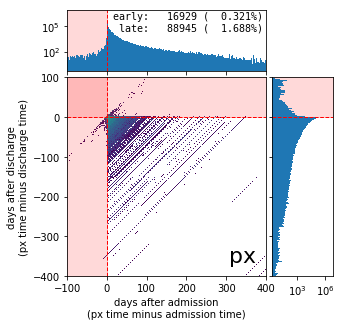

In [27]:
lbl = 'px'
# X, Y = dfs[lbl].days_after_adm, dfs[lbl].days_after_disch
# summarize_evts_in_periods(X, Y, lbl)
# plt.show()
# X, Y = dfs[lbl].days_after_adm_notime, dfs[lbl].days_after_disch_notime
X, Y = dfs[lbl].days_after_adm_notime, dfs[lbl].days_after_disch_notime
fig = summarize_evts_in_periods(X, Y, lbl)
# plt.tight_layout()
fig.savefig('test.png', bbox_inches='tight', dpi=72)
plt.show()
del fig
plt.close('all')

In [40]:
%%time

for lbl in lbls[1:]:
#     is_outpatient = dfs[lbl].class_code == 'E'
    df = dfs[lbl] #[is_outpatient]
    X, Y = df.days_after_adm_notime, df.days_after_disch_notime
    fig = summarize_evts_in_periods(X, Y, lbl)
    fn = 'clindat_obsperiod_summary_%s.png'%lbl
    fig.savefig(fn, bbox_inches='tight')
    print(fn)
    del fig
    plt.close('all')

clindat_obsperiod_summary_dx.png
clindat_obsperiod_summary_px.png
clindat_obsperiod_summary_lab.png
clindat_obsperiod_summary_mo.png
clindat_obsperiod_summary_ma.png
clindat_obsperiod_summary_vit.png
CPU times: user 39.6 s, sys: 8.86 s, total: 48.5 s
Wall time: 32.7 s


In [41]:
%%time

for lbl in lbls[1:]:
    for class_code in ['I', 'E', 'O']:
        df = dfs[lbl][dfs[lbl].class_code==class_code]
        X, Y = df.days_after_adm_notime, df.days_after_disch_notime
        fig = summarize_evts_in_periods(X, Y, '%s (%s)'%(lbl, class_code))
        fn = 'clindat_obsperiod_summary_%s_%s.png'%(lbl, class_code)
        fig.savefig(fn, bbox_inches='tight')
        print(fn)
        del df
        del fig
        plt.close('all')

clindat_obsperiod_summary_dx_I.png
clindat_obsperiod_summary_dx_E.png
clindat_obsperiod_summary_dx_O.png
clindat_obsperiod_summary_px_I.png
clindat_obsperiod_summary_px_E.png
clindat_obsperiod_summary_px_O.png
clindat_obsperiod_summary_lab_I.png
clindat_obsperiod_summary_lab_E.png
clindat_obsperiod_summary_lab_O.png
clindat_obsperiod_summary_mo_I.png
clindat_obsperiod_summary_mo_E.png
clindat_obsperiod_summary_mo_O.png
clindat_obsperiod_summary_ma_I.png
clindat_obsperiod_summary_ma_E.png
clindat_obsperiod_summary_ma_O.png
clindat_obsperiod_summary_vit_I.png
clindat_obsperiod_summary_vit_E.png
clindat_obsperiod_summary_vit_O.png
CPU times: user 1min 27s, sys: 17.4 s, total: 1min 44s
Wall time: 1min 13s


In [59]:
cols = ['visit_end_date', 'StartDate', 'days_after_disch_notime']
dfs['px'][cols][dfs['px'].days_after_disch_notime>0].head(10)

visit_end_date  StartDate  days_after_disch_notime
186            NaN 2017-05-16                   124053
204            NaN 2017-05-19                   124056
205            NaN 2017-04-19                   124026
206            NaN 2017-05-19                   124056
219            NaN 2017-05-25                   124062
220            NaN 2017-05-25                   124062
221            NaN 2017-05-25                   124062
473            NaN 2017-05-16                   124053
490            NaN 2017-05-28                   124065
491            NaN 2017-05-26                   124063

In [13]:
print('test')

test


In [21]:
for lbl in lbls[1:]:
    df = dfs[lbl]
    X_early = -1*df.days_after_disch_notime
    X_late = df.days_after_disch_notime[~df.visit_end_date.isnull()]
    with pd.option_context('float_format', '{:.1f}'.format):
        print('%s\t%.3f (%.3f)\t%.3f (%.3f)'%(lbl, X_early.quantile(0.99), X_early.max(), X_late.quantile(0.99), X_late.max()))
#         desc = X_early[X_early>0].describe(percentiles=[0.50,0.95,0.975,0.99,0.9999])
#         print('**** %s **** before admission'%lbl)
#         print('%s'%desc)
#         desc = X_late[X_late>0].describe(percentiles=[0.50,0.95,0.975,0.99,0.9999])
#         print('**** %s **** after discharge'%lbl)
#         print('%s'%desc)

dx	-1.000 (736.000)	11.000 (935.000)
px	64.000 (1018.000)	0.000 (1034.000)
lab	67.000 (731.000)	14.000 (1114.000)
mo	38.000 (746.000)	4.000 (654.000)
ma	85.000 (731.000)	7.000 (1156.000)
vit	25.000 (781.000)	5.000 (750.000)


In [21]:
print('test')

test


In [18]:
def draw_outoftime(s, lbl, early=True, xhi=None):
    s = s[(~s.isnull()) & (s>0)]
    q = 0.99
    if xhi is None:
#         xhi = s.max()
        xhi = 1.1*s.quantile(q)
#     rho = len(s<=xhi)/len(s)
    fig = plt.figure(figsize=(5, 3))
    plt.hist(s.values, bins=pd.np.arange(0,xhi+0.5,1), cumulative=True, density=1)
    xlbl_prep = 'before admission' if early else 'after discharge'
    xlbl = '%s days %s'%(lbl, xlbl_prep)
    plt.xlabel(xlbl)
    plt.ylabel('cumulative fraction of %s'%lbl)
    with pd.option_context('float_format', '{:.1f}'.format):
        desc = s.describe(percentiles=[0.50,0.95,0.975,0.9999])
        plt.text(0.9, 0.5, desc.to_string(), color='white', family='monospace',
                 transform=plt.gca().transAxes, horizontalalignment='right',
                 verticalalignment='center')
    plt.ylim(0,1.025)
    plt.xlim(0, xhi)
    # plt.savefig('visit_latency_MUSC_to_HSSC.png', bbox_inches='tight')
    if early:
        plt.savefig('cdf_%s_early.png'%lbl, bbox_inches='tight')
    else:
        plt.savefig('cdf_%s_late.png'%lbl, bbox_inches='tight')

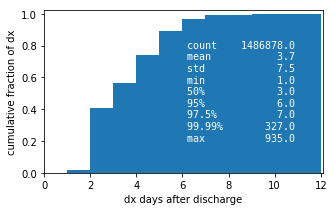

In [22]:
lbl = 'dx'
# fig = draw_outoftime(-1*dfs[lbl].days_after_adm_notime, lbl, early=True)
# plt.show()
fig = draw_outoftime(dfs[lbl].days_after_disch_notime[~(dfs[lbl].visit_end_date.isnull())], lbl, early=False) #, xhi=200)
plt.show()

dx 2
px 2
lab 2
mo 2
ma 2
vit 2


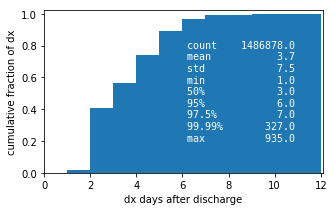

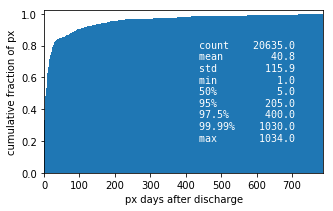

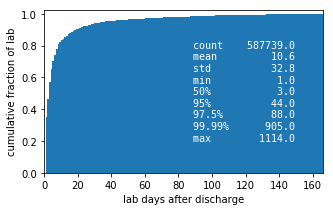

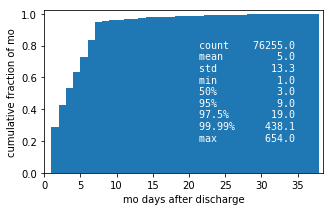

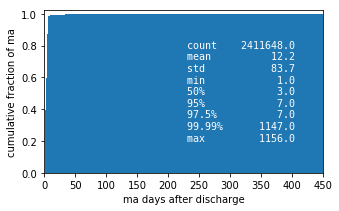

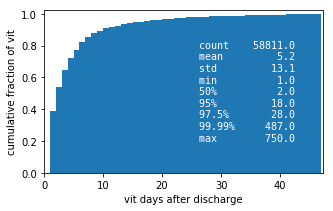

In [24]:
# for lbl in lbls[1:]:
#     print(lbl,'1')
#     fig = draw_outoftime(-1*dfs[lbl].days_after_adm_notime, lbl, early=True)
#     plt.savefig('cdf_%s_early.png'%lbl, bbox_inches='tight')
for lbl in lbls[1:]:
    print(lbl,'2')
    has_disch = ~(dfs[lbl].visit_end_date.isnull())
    draw_outoftime(dfs[lbl].days_after_disch_notime[has_disch], lbl, early=False)
#     plt.savefig('cdf_%s_late.png'%lbl, bbox_inches='tight')

In [23]:
dfs['dx'].days_after_disch_notime.value_counts()

 2         575172
 4         261933
 3         231627
 5         217576
 6         111361
 7          37823
 1          23077
 8           6741
 9           3187
 10          2153
 11          1739
 13          1360
 14          1162
 12          1152
 31          1060
 32           731
 27           722
 26           684
 15           656
 0            641
 30           615
 29           564
 28           546
 20           524
 25           499
 16           475
 18           470
 17           433
-1            430
 24           419
            ...  
 90             1
 75             1
 722            1
 720            1
 719            1
 716            1
 124008         1
 714            1
 708            1
 87             1
 707            1
 88             1
 706            1
 704            1
 699            1
 689            1
 92             1
 124001         1
 96             1
 695            1
 123993         1
 104            1
 107            1
 123984         1
 123980   

In [ ]:
del fig
plt.close('all')

In [44]:
for lbl in lbls:
    df = dfs[lbl]
    is_in_encfile = df.VISIT_ID.isin(dfs['enc'].VISIT_ID)
    nrecs = len(df)
    n_uniq_encs = len(df.VISIT_ID.value_counts())
#     tabular.coalesce()
    print(lbl, sum(df.htb_enc_act_id.isnull())/nrecs, 1-len(df[is_in_encfile|~(df.htb_enc_act_id.isnull())])/nrecs,
          1-len(df.htb_enc_act_id.value_counts())/n_uniq_encs,
          1-len(df[is_in_encfile|~(df.htb_enc_act_id.isnull())].VISIT_ID.value_counts())/n_uniq_encs
         )

enc 0.02187462183153002 0.0 0.030035330010151684 0.0
dx 0.0009535842212529082 0.0005322175240466409 0.9899683605190586 0.00042756055326331754
px 0.0027774240255718876 0.0008546358061466419 0.977160990959759 0.0008960238939704768
lab 0.0019441583054126434 0.0009819362914823548 0.9837249233207613 0.0003424272219857416
mo 0.004951409933642282 0.0013499194588555419 0.9621211725385903 0.0018565832945819372
ma 0.004976759005583104 0.0033211974740362527 0.9723652621690269 0.0007219651369124724
vit 0.0006039355346142385 0.00037799403025906564 0.9907776319243896 0.0002751378314518327


In [206]:
import datetime
df = dfs['dx']
print(100*sum(df.class_code.isnull()/len(df)))
print(df[(df['#UniqueID'].str.endswith('.12'))&(df.StartDate>df.visit_end_date)&(df.StartDate>datetime.datetime(2017,6,6))&(df.ADMIT_DATE>datetime.datetime(2017,6,6))].head(2).T)
print(df[df['#UniqueID']=='1094471360.1.12'].T)
df[df['#UniqueID']=='1094471360.1.12'].htb_enc_act_id.astype(str)

0.09535842212529015
                                         249                  551
#UniqueID                    1094471360.1.12      1094784989.1.12
VISIT_ID                          1094471360           1094784989
ADMIT_DATE               2017-06-06 08:17:00  2017-06-07 11:51:00
StartDate                2017-06-08 17:55:56  2017-06-08 11:45:30
EndDate                  2017-06-08 17:55:56  2017-06-08 11:45:30
htb_enc_id_ext                    1094471360           1094784989
htb_enc_act_id                   3.06455e+11          3.06455e+11
visit_start_date         2017-06-06 08:17:00  2017-06-07 11:51:00
visit_end_date           2017-06-06 11:56:00  2017-06-07 12:42:00
class_code                                 O                    O
type_code                                 OS                   OG
has_pdx                                    0                    0
has_dxs                                    1                    1
has_pxs                                    1            

249    306454973101.0
Name: htb_enc_act_id, dtype: object

### Evaluate visit-reference integrity of one batch

In looking at one batch, it's manageable to retain and view counts of all *existence patterns* -- i.e., of all the visit numbers in all the files of one batch, how many appear in (1) just the `visit` file, (2) the `visit` file and the `diagnosis` file, (3) `visit`, `diagnosis`, and `procedure`, ... (m) just the `vital` files, ... (n) all files.  From that *foundational* summary, it is easy to answer many questions, like, "What fraction of visit numbers in the `lab result` file are in the `visit` file?"

Extending the idea to *count patterns* allows us, analogously, to answer questions like, like, "What fraction of `lab result` records reference visits that exist in the `visit` file?"

In [24]:
def get_count_patterns(d0):
    fn_persist = '%d_cnt_ptrns.csv.gz'%d0
    try:
        df = pd.read_csv(fn_persist, compression='infer', dtype=str)
        df.set_index('vnum', inplace=True)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
    except FileNotFoundError as e:
        print('File %s not found.'%fn_persist)
        print('Getting batch from file server.')
        fns = get_batch_files(d0)
        # VISIT_ID is the standard columns name for the column that contains
        #   visit numbers
        cnames_vnum = ['VISIT_ID']*len(fns)
        cnames_vnum[0] = '#VISIT_ID'  # ... but the VISITS files has a leading "#"

        ss_nrecs_per_vnum = collections.OrderedDict()
        pwd = getpass.getpass('key phrase:')
        for ((clin, fp), keycol) in zip(fns.items(), cnames_vnum):
            print('%s@%s:%s'%(usr,srvr,fp))
            try:
                with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
                    ufin = fin
                    if fp.endswith('gpg'):
                        ufin = cryptic.decrypt(fin, pwd=pwd, ostream=True)
                    s = pd.read_csv(ufin, sep='|', dtype=str,
                                    usecols=[keycol], squeeze=True, encoding='ISO-8859-1')
                    ss_nrecs_per_vnum[clin] = s.value_counts()
            except FileNotFoundError as e:
                ss_nrecs_per_vnum[clin] = pd.Series()
        df = pd.DataFrame(ss_nrecs_per_vnum)
        df.to_csv(fn_persist, compression='gzip', index_label='vnum')
    df = df.fillna(0).astype(pd.np.int)
    tabular.shrink_df(df)
    return df


def calc_fracs(df_cnt_ptrns, col):
    has_cdw = df_cnt_ptrns.cdw > 0
    has_enc = df_cnt_ptrns.enc > 0
    n_has_enc = sum(df_cnt_ptrns.loc[has_enc,col])
    n_has_cdw = sum(df_cnt_ptrns.loc[has_cdw,col])
    n_has_enc_or_cdw = sum(df_cnt_ptrns.loc[has_enc|has_cdw,col])
    n_all = sum(df_cnt_ptrns.loc[:,col])
    if n_all == 0:
        return tuple(((0,0),(0,0),(0,0)))
    return tuple((n_all-n, 1-n/n_all) for n in [n_has_enc, n_has_cdw, n_has_enc_or_cdw])


def print_all_fracs(dfs):
    for lbl in lbls[1:]:
        print('%s:%d'%(lbl, sum(dfs[0].loc[:,lbl])))
        for df in dfs:
            fns = []
            for (f,n) in calc_fracs(df, lbl):
                fns.append(f)
                fns.append(n)
            print('%16d (%.5f)%8d (%.5f)%8d (%.5f)'%tuple(fns))

In [50]:
%time df_cnt_ptrns = get_count_patterns(20170421)
%time df_exst_ptrns = df_cnt_ptrns > 0 

File 20170421_cnt_ptrns.csv.gz not found.
Getting batch from file server.
key phrase:········
phelpse@hssc-smilecdr-d:/data/stage/MUSC/visits/done/MUSC_RDW_VISIT_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/diags/done/MUSC_RDW_DIAGNOSIS_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/procs/done/MUSC_RDW_PROCEDURE_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/labs/done/MUSC_RDW_LAB_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/medOrders/done/MUSC_RDW_MED_ORDER_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/medAdmins/done/MUSC_RDW_MED_ADMIN_20170416_20170422.dat
phelpse@hssc-smilecdr-d:/data/stage/MUSC/vitals/done/MUSC_RDW_VITALS_20170416_20170422.dat
CPU times: user 15.1 s, sys: 2.11 s, total: 17.2 s
Wall time: 54.9 s
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.98 ms


In [51]:
%time df_cnt_ptrns['cdw'] = df_cnt_ptrns.index.isin(df_cdw_vnums.htb_enc_id_ext)
%time df_cnt_ptrns['cdw'] = df_cnt_ptrns.cdw.apply(lambda x: 1 if x else 0)
%time df_exst_ptrns['cdw'] = df_exst_ptrns.index.isin(df_cdw_vnums.htb_enc_id_ext)

CPU times: user 1.28 s, sys: 45 ms, total: 1.33 s
Wall time: 1.32 s
CPU times: user 45 ms, sys: 0 ns, total: 45 ms
Wall time: 44 ms
CPU times: user 1.34 s, sys: 37 ms, total: 1.37 s
Wall time: 1.37 s


In [52]:
tabular.freq(df_exst_ptrns, ['enc', 'dx', 'px'])

enc     dx     px  COUNT       PERC     CUMPERC
1  False  False   True  63144  49.741227   49.741227
4   True  False  False  23861  18.796329   68.537556
5   True  False   True  21314  16.789948   85.327504
7   True   True   True  10169   8.010556   93.338060
6   True   True  False   5543   4.366458   97.704518
0  False  False  False   1120   0.882272   98.586790
2  False   True  False   1027   0.809012   99.395801
3  False   True   True    767   0.604199  100.000000

In [53]:
def field_or(df, lst):
    retval = df[lst[0]]
    for el in lst[1:]:
        retval = retval | df[el]
    return retval

In [54]:
df_exst_ptrns['any'] = field_or(df_exst_ptrns, ['dx', 'px', 'lab', 'mo', 'ma', 'vit'])

In [55]:
df_exst_ptrns[~(df_exst_ptrns['any'])].head()

enc     dx     px    lab     mo     ma    vit   cdw    any
1001250949  True  False  False  False  False  False  False  True  False
1001509835  True  False  False  False  False  False  False  True  False
1001510789  True  False  False  False  False  False  False  True  False
1001522617  True  False  False  False  False  False  False  True  False
1001523120  True  False  False  False  False  False  False  True  False

In [56]:
print(sum(df_cnt_ptrns.px))
print(len(df_cnt_ptrns))

194730
126945


In [98]:
print_all_fracs([df_cnt_ptrns, df_exst_ptrns])

dx:55893
            9288 (0.16617)      55 (0.00098)      55 (0.00098)
            1794 (0.10248)       7 (0.00040)       7 (0.00040)
px:194730
          130848 (0.67195)     425 (0.00218)     425 (0.00218)
           63911 (0.66997)     228 (0.00239)     228 (0.00239)
lab:339492
           80494 (0.23710)      31 (0.00009)      31 (0.00009)
            1502 (0.15584)       9 (0.00093)       9 (0.00093)
mo:0
               0 (0.00000)       0 (0.00000)       0 (0.00000)
               0 (0.00000)       0 (0.00000)       0 (0.00000)
ma:289244
          142772 (0.49360)     292 (0.00101)     292 (0.00101)
             904 (0.14834)       4 (0.00066)       4 (0.00066)
vit:66261
            3929 (0.05930)      29 (0.00044)      29 (0.00044)
            1204 (0.05789)      13 (0.00063)      13 (0.00063)


In [99]:
df_exst_ptrns_freq = tabular.freq(df_exst_ptrns.applymap(lambda x: 'X' if x else '-'), ['cdw'] + lbls)

In [100]:
df_exst_ptrns_freq.head()

cdw enc dx px lab mo ma vit  COUNT       PERC    CUMPERC
15   X   -  -  X   -  -  -   -  61951  48.801449  48.801449
39   X   X  -  -   -  -  -   -  21106  16.626098  65.427547
47   X   X  -  X   -  -  -   -  11641   9.170113  74.597660
48   X   X  -  X   -  -  -   X   6259   4.930482  79.528142
64   X   X  X  X   -  -  -   X   3867   3.046201  82.574343

In [17]:
df_cnt_ptrns_freq = tabular.freq(df_cnt_ptrns, ['cdw'] + lbls)

In [18]:
df_cnt_ptrns_freq.tail()

cdw  enc  dx  px  lab  mo   ma  vit  COUNT      PERC     CUMPERC
3593    1    1   0   4    0   0    3    0      1  0.000621   99.997517
3592    1    1   0   4    0   0    1    0      1  0.000621   99.998138
3586    1    1   0   3  278  19   28    2      1  0.000621   99.998758
3585    1    1   0   3  232  22  138    6      1  0.000621   99.999379
9379    1    1  42  31    5   0  173    0      1  0.000621  100.000000

In [19]:
df_cnt_ptrns.head()

enc  dx  px  lab  mo  ma  vit  cdw
1001507830    0   0   0    0   2   0    0    0
1001511762    0   0   2    0   0   0    0    1
1001512837    1   0   0    0   0   0    0    1
1001514107    0   0   0    0   1   0    0    1
1001517439    0   0   0    0   1   0    0    0

In [20]:
calc_fracs(df_cnt_ptrns, 'px')

(0.2986764487693071, 0.9974674995779166, 0.0)

In [21]:
calc_fracs(df_exst_ptrns, 'dx')

(0.8988239573229874, 0.9997575169738119, 0.0)

### Summarize batch-to-batch visit-reference integrity

In [101]:
for k in batch_files:
    print(k)

(20170604, 20170610)
(20170611, 20170617)
(20170618, 20170624)
(20170625, 20170701)
(20170702, 20170708)
(20170709, 20170715)
(20170716, 20170722)
(20170723, 20170729)
(20170730, 20170805)
(20170806, 20170812)
(20170813, 20170819)
(20170820, 20170826)
(20170827, 20170902)
(20170305, 20170311)
(20170312, 20170318)
(20170319, 20170325)
(20170326, 20170401)
(20170402, 20170408)
(20170409, 20170415)
(20170416, 20170422)
(20170423, 20170429)
(20170430, 20170506)
(20170507, 20170513)
(20170514, 20170520)
(20170521, 20170527)
(20170528, 20170603)


In [11]:
def get_fracs_tuples(d0, lbls, df_cdw_vnums):
    df_cnt_ptrns = get_count_patterns(d0)
    df_exst_ptrns = df_cnt_ptrns > 0
    df_cnt_ptrns['cdw'] = df_cnt_ptrns.index.isin(df_cdw_vnums.htb_enc_id_ext)
    df_cnt_ptrns['cdw'] = df_cnt_ptrns.cdw.apply(lambda x: 1 if x else 0)
    df_exst_ptrns['cdw'] = df_exst_ptrns.index.isin(df_cdw_vnums.htb_enc_id_ext)
    tuples = []
    for lbl in lbls:
        fracs_vnums_uniq = calc_fracs(df_exst_ptrns, lbl)
        fracs_vnums_recs = calc_fracs(df_cnt_ptrns, lbl)
        tuples.append((lbl,) + fracs_vnums_recs + fracs_vnums_uniq)
    return tuples

In [184]:
df_cdw_vnums = get_cdw_vnums()

1999.1516723632812


In [185]:
df_cdw_vnums.head().visit_start_date.values

array(['2017-11-14 09:53:00', '2017-11-14 15:26:00',
       '2017-11-14 13:16:00', '2017-11-15 12:55:00',
       '2017-11-13 10:53:00'], dtype=object)

In [13]:
%time get_fracs_tuples(20170827, lbls, df_cdw_vnums=df_cdw_vnums)

CPU times: user 25.6 s, sys: 1.56 s, total: 27.2 s
Wall time: 27.2 s


[('enc',
  1.0,
  0.9790873273015201,
  0.020912672698479802,
  1.0,
  0.9790873273015201,
  0.020912672698479802),
 ('dx',
  0.8737916123152797,
  0.99438914997409,
  0.0005003305755588513,
  0.9239762746663625,
  0.9969773012432988,
  0.00011406410402646287),
 ('px',
  0.46838935581989327,
  0.9967921193619698,
  0.00045985162859501474,
  0.4795435092724679,
  0.9978544935805992,
  0.0005135520684736092),
 ('lab', 0, 0, 0, 0, 0, 0),
 ('mo',
  0.6148743038632847,
  0.9948380953574181,
  0.000375866842906453,
  0.4508693144363876,
  0.9950148319050758,
  0.0007415952537903757),
 ('ma',
  0.5387563082176303,
  0.9859681387933416,
  0.0003326721735418916,
  0.8424030620735563,
  0.9921783990680646,
  0.00016641704110500916),
 ('vit',
  0.9512644525312083,
  0.9972208147158629,
  0.0,
  0.9553050913330743,
  0.9971822774970851,
  0.0)]

In [44]:
%%time

batch_stats_vnum_integrity = {k[0]:get_fracs_tuples(k[0], lbls, df_cdw_vnums)
                              for k in batch_files}

CPU times: user 2min, sys: 4.52 s, total: 2min 4s
Wall time: 2min 4s


In [46]:
batch_stats_vnum_integrity

{20170305: [('enc', 1.0, 1.0, 0.0, 1.0, 1.0, 0.0),
  ('dx',
   0.8402508361204013,
   0.9995986622073578,
   0.0,
   0.9075453367875648,
   0.9996761658031088,
   0.0),
  ('px',
   0.33282233966965474,
   0.994953329245384,
   0.0,
   0.3329639889196676,
   0.9936942835557794,
   0.0),
  ('lab',
   0.7757994893344172,
   0.999874051089458,
   0.0,
   0.852501191043354,
   0.9990471653168176,
   0.0),
  ('mo',
   0.44008610658599023,
   0.994298347684431,
   0.0,
   0.27547215412768017,
   0.9913682974829956,
   0.0),
  ('ma',
   0.5197353309220564,
   0.9998765791864511,
   0.0,
   0.8480013436345314,
   0.9994961370507222,
   0.0),
  ('vit',
   0.9444361819209376,
   0.9999405098307504,
   0.0,
   0.9475431606905711,
   0.9999051413394043,
   0.0)],
 20170312: [('enc', 1.0, 1.0, 0.0, 1.0, 1.0, 0.0),
  ('dx',
   0.8572560621268952,
   0.9999295613432652,
   0.0,
   0.9173618498404345,
   0.9998320362801635,
   0.0),
  ('px',
   0.3264425952016542,
   0.9957733202242066,
   0.0,
   0.32

At this point, it looks like (not shown in this notebook) many of the encounters are not arriving until after corresponding clinical data.  This is bad because the clinical data will be rejected and never processed unless a new version of the same clinical data arrives *after* the corresponding encounter is finally received and processed.

CDW does not preserve the original creation date of an encounter, so I'll need to get it from HTB.  To limit the amount of data, I would like to limit by date.  Accordingly, I want the minimum date of all the visits referenced in the batches.  I already have the visit dates for all encounters in CDW.

So, first I'll get all the visits referenced in the batches already processed above:

```
for fn in $(ls 2017*.csv.gz)
do
    gunzip -c ${fn} | awk -F',' '{if (NR!=1) {print $1}}'
done | sort | uniq > vnums_all_in_batch_union.txt
```

Then, I'll find the distribution of dates and decide how far back to go in HTB.

In [29]:
vnums_all = pd.read_table('vnums_all_in_batch_union.txt', dtype=str, header=None, names=['vnum'])

In [187]:
( df_cdw_vnums.loc[df_cdw_vnums.htb_enc_id_ext.isin(vnums_all.vnum)]
  .visit_start_date.str[:7].value_counts().sort_index() ).head()

2014-07    76566
2014-08    76164
2014-09    80009
2014-10    90207
2014-11    74009
Name: visit_start_date, dtype: int64

***The cost of the HTB query is too high.***

So, the alternative will be to look at only the encounters with version = 1.  Those will have `last_update_date` values that are equal to the creation date.  Another complication is that the version numbers are not updated in CDW, where versioning is not used!  Accordingly, I'll have to get the version numbers from the staging tables.

In [150]:
%%time

sql_dnums = '''select /*+ parallel 4 */ distinct
                 enc_act_id htb_enc_act_id,
                 diagnosis_start_date,
                 last_update_date
               from cdw.diag_staging
               where patient_id_root in ('2.16.840.1.113883.3.2489.2.1.2.1.3.1.2.2',
                                     '2.16.840.1.113883.3.2489.2.1.2.2.2.1')
                 and diag_act_version_num = 1
                 and diagnosis_start_date >= to_date('20170101', 'YYYYMMDD')
                 and diagnosis_start_date < to_date('20180101', 'YYYYMMDD')
            '''
df_v1s_d = tabular.df_from_sql(sql_dnums, engine=engine)

CPU times: user 1.92 s, sys: 181 ms, total: 2.1 s
Wall time: 1min 10s


In [313]:
%%time

fp = '/data/stage/MUSC/diags/done/MUSC_RDW_DIAGNOSIS_20170409_20170415.dat'

df_dx_1 = None
with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
    # instead of sampling, I'll just take the first records from each file
    this_df = pd.read_table(fin, sep='|', dtype=str, usecols=[1,4,9])
    df_dx_1 = this_df if df_dx_1 is None else df_dx_1.append(this_df, ignore_index=True)

CPU times: user 600 ms, sys: 83 ms, total: 683 ms
Wall time: 2.69 s


In [314]:
%%time

dcrit = 20170409
df_encs = None
for ((d0,d1),fps) in batch_files.items():
    fp = fps['enc']
    with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
        this_df = pd.read_table(fin, sep='|', dtype=str, usecols=[0,5,6,7])
        this_df['reltime'] = pd.np.sign(d0-dcrit)
        this_df['d0'] = d0
        df_encs = this_df if df_encs is None else df_encs.append(this_df, ignore_index=True)

CPU times: user 1min 34s, sys: 16.7 s, total: 1min 50s
Wall time: 4min 20s


In [315]:
df_encs.head()

#VISIT_ID VISIT_STATUS PATIENT_CLASS PATIENT_TYPE  reltime        d0
0  1066247924            2             O          109        1  20170604
1  1104234794          NaN             E          103        1  20170604
2  1099351953            6             O          102        1  20170604
3  1104622228          NaN             E          103        1  20170604
4  1104017243            2             O          127        1  20170604

In [464]:
df_dx_1_encs = df_dx_1.merge(df_encs, left_on='VISIT_ID', right_on='#VISIT_ID')
df_dx_1_encs.head(3).T

0               1               2
VISIT_ID           1061411553      1061411553      1061411553
ADMIT_DATE     20160401083800  20160401083800  20160401083800
StartDate      20160406185024  20160406185024  20160406185024
#VISIT_ID          1061411553      1061411553      1061411553
VISIT_STATUS              NaN             NaN             NaN
PATIENT_CLASS               I               I               I
PATIENT_TYPE              101             101             101
reltime                     1               0               1
d0                   20170813        20170409        20170813

In [465]:
df_dx_1_encs.reltime.value_counts()/len(df_dx_1_encs)

 1    0.582156
 0    0.241167
-1    0.176677
Name: reltime, dtype: float64

In [466]:
df_dx_1_encs['dcrit'] = dcrit

In [467]:
df_dx_1_encs['latency_weeks'] = \
    round( (pd.to_datetime(df_dx_1_encs.dcrit, format='%Y%m%d') - pd.to_datetime(df_dx_1_encs.d0, format='%Y%m%d'))
      .astype('timedelta64[h]')/(24*7) )

In [468]:
df_dx_1_encs.head()

VISIT_ID      ADMIT_DATE       StartDate   #VISIT_ID VISIT_STATUS  \
0  1061411553  20160401083800  20160406185024  1061411553          NaN   
1  1061411553  20160401083800  20160406185024  1061411553          NaN   
2  1061411553  20160401083800  20160406185024  1061411553          NaN   
3  1061411553  20160401083800  20160406185024  1061411553          NaN   
4  1061411553  20160401083800  20160406185024  1061411553          NaN   

  PATIENT_CLASS PATIENT_TYPE  reltime        d0     dcrit  latency_weeks  
0             I          101        1  20170813  20170409          -18.0  
1             I          101        0  20170409  20170409            0.0  
2             I          101        1  20170813  20170409          -18.0  
3             I          101        0  20170409  20170409            0.0  
4             I          101        1  20170813  20170409          -18.0

In [469]:
df_dx_1_encs = df_dx_1_encs.merge(df_v1s, left_on='VISIT_ID', right_on='htb_enc_id_ext')

In [470]:
df_dx_1_encs.last_update_date.head()

0   2017-03-03 22:40:25
1   2017-03-03 22:40:25
2   2017-03-03 22:40:25
3   2017-03-03 22:40:25
4   2017-03-03 22:40:25
Name: last_update_date, dtype: datetime64[ns]

In [471]:
df_dx_1_encs.last_update_date.value_counts()

2017-05-05 13:57:26    148139
2017-04-03 17:05:50     13032
2017-04-03 10:02:23     11908
2017-03-06 10:09:17      5144
2017-03-06 14:35:54      2044
2017-05-06 10:20:18      1148
2017-03-03 22:40:25       447
2017-01-17 18:48:26       246
2017-06-14 12:33:40       172
Name: last_update_date, dtype: int64

In [472]:
pd.to_datetime(dcrit, format='%Y%m%d')

Timestamp('2017-04-09 00:00:00')

In [473]:
bulk_loader_offset = pd.to_timedelta('27 days') # May 5 or 6
df_dx_1_encs['latency_weeks_cdw'] = \
    pd.np.round( (pd.to_datetime(dcrit, format='%Y%m%d') - (df_dx_1_encs.last_update_date-bulk_loader_offset))
      .astype('timedelta64[h]')/(24*7) )

In [474]:
df_dx_1_encs.latency_weeks_cdw.value_counts().sort_index()

-6.0        172
 0.0     149287
 5.0      24940
 9.0       7635
 15.0       246
Name: latency_weeks_cdw, dtype: int64

In [475]:
df_dx_1_encs.latency_weeks.value_counts().sort_index()

-20.0    13164
-19.0    15229
-18.0    20399
-17.0      698
-16.0     1273
-15.0      818
-14.0     1003
-13.0     1019
-12.0      786
-11.0     2176
-10.0     2166
-9.0      1217
-8.0      1455
-7.0      1330
-6.0      2341
-5.0      2694
-4.0      4216
-3.0      4414
-2.0      7037
-1.0     22611
 0.0     44098
 1.0     20171
 2.0      4102
 3.0      3457
 4.0      2334
 5.0      2072
Name: latency_weeks, dtype: int64

In [476]:
print(pd.np.sign(df_dx_1_encs.latency_weeks_cdw).value_counts())
print(pd.np.sign(df_dx_1_encs.latency_weeks).value_counts())
print(df_dx_1_encs.reltime.value_counts())

 0.0    149287
 1.0     32821
-1.0       172
Name: latency_weeks_cdw, dtype: int64
-1.0    106046
 0.0     44098
 1.0     32136
Name: latency_weeks, dtype: int64
 1    106046
 0     44098
-1     32136
Name: reltime, dtype: int64


In [477]:
len(df_dx_1_encs[df_dx_1_encs.latency_weeks_cdw<0])

172

In [339]:
%%time

df_dxs = None
for ((d0,d1),fps) in batch_files.items():
    fp = fps['dx']
    with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
        this_df = pd.read_table(fin, sep='|', dtype=str, usecols=[1,4,9])
        this_df['d0'] = d0
        this_df['d1'] = d1
        df_dxs = this_df if df_dxs is None else df_dxs.append(this_df, ignore_index=True)

CPU times: user 29 s, sys: 4.41 s, total: 33.4 s
Wall time: 1min 25s


In [478]:
%%time

df_encs = None
for ((d0,d1),fps) in batch_files.items():
    fp = fps['enc']
    with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
        this_df = pd.read_table(fin, sep='|', dtype=str, usecols=[0,5,6,7])
        this_df['d0'] = d0
        this_df['d1'] = d1
        df_encs = this_df if df_encs is None else df_encs.append(this_df, ignore_index=True)

CPU times: user 1min 33s, sys: 18.6 s, total: 1min 52s
Wall time: 4min 22s


In [485]:
print(min(df_encs.d0), max(df_encs.d0))

20170305 20170827


20170827

In [486]:
%%time

df_pxs = None
for ((d0,d1),fps) in batch_files.items():
    fp = fps['px']
    with cryptic.fopen('%s@%s:%s'%(usr,srvr,fp)) as fin:
        this_df = pd.read_table(fin, sep='|', dtype=str, usecols=[1,4,9])
        this_df['d0'] = d0
        this_df['d1'] = d1
        df_pxs = this_df if df_pxs is None else df_pxs.append(this_df, ignore_index=True)

CPU times: user 1min 47s, sys: 18.7 s, total: 2min 5s
Wall time: 5min 2s


In [298]:
df_dx_1_encs = df_dx_1.merge(df_v1s, left_on='VISIT_ID', right_on='htb_enc_id_ext')

In [205]:
df_dx_1_encs['px_date'] = pd.to_datetime(df_dx_1_encs.StartDate.str[0:8], format='%Y%m%d')

In [206]:
df_dx_1_encs.px_date

VISIT_ID      ADMIT_DATE       StartDate htb_enc_id_ext  htb_enc_act_id  \
0  1080706411  20170113092700  20170118194946     1080706411    286945527001   
1  1080706411  20170113092700  20170118194946     1080706411    286945527001   
2  1080706411  20170113092700  20170118194946     1080706411    286945527001   
3  1080706411  20170113092700  20170118194946     1080706411    286945527001   
4  1080706411  20170113092700  20170118194946     1080706411    286945527001   

       enc_start_date        enc_end_date    last_update_date    px_date  
0 2017-01-13 09:27:00 2017-01-13 17:32:00 2017-03-03 22:40:25 2017-01-18  
1 2017-01-13 09:27:00 2017-01-13 17:32:00 2017-03-03 22:40:25 2017-01-18  
2 2017-01-13 09:27:00 2017-01-13 17:32:00 2017-03-03 22:40:25 2017-01-18  
3 2017-01-13 09:27:00 2017-01-13 17:32:00 2017-03-03 22:40:25 2017-01-18  
4 2017-01-13 09:27:00 2017-01-13 17:32:00 2017-03-03 22:40:25 2017-01-18

In [101]:
%%time

sql_pnums = '''select /*+ parallel 4 */ distinct
                 enc_act_id htb_enc_act_id,
                 proc_start_date,
                 last_update_date
               from cdw.proc_staging
               where patient_id_root in ('2.16.840.1.113883.3.2489.2.1.2.1.3.1.2.2',
                                     '2.16.840.1.113883.3.2489.2.1.2.2.2.1')
                 and proc_act_version_num = 1
                 and proc_start_date >= to_date('20170101', 'YYYYMMDD')
                 and proc_start_date < to_date('20180101', 'YYYYMMDD')
            '''
df_v1s_p = tabular.df_from_sql(sql_pnums, engine=engine)

CPU times: user 3.52 s, sys: 310 ms, total: 3.83 s
Wall time: 52.9 s


In [93]:
%%time

sql_vnums = '''select /*+ parallel 4 */ distinct
                 enc_ext htb_enc_id_ext,
                 enc_act_id htb_enc_act_id,
                 enc_start_date, enc_end_date,
                 last_update_date
               from cdw.enc_staging
               where enc_root_id in ('2.16.840.1.113883.3.2489.2.1.2.1.3.1.2.4',
                                     '2.16.840.1.113883.3.2489.2.1.2.2.3.1.2.2')
                 and enc_act_version_num = 1
                 and enc_start_date >= to_date('20170101', 'YYYYMMDD')
                 and enc_start_date < to_date('20180101', 'YYYYMMDD')
            '''
df_v1s = tabular.df_from_sql(sql_vnums, engine=engine)

CPU times: user 7.56 s, sys: 939 ms, total: 8.5 s
Wall time: 1min 3s


In [94]:
df_v1s.head()

htb_enc_id_ext  htb_enc_act_id      enc_start_date        enc_end_date  \
0     1113177112    323314738801 2017-10-02 14:05:00 2017-10-02 23:59:00   
1     1113161933    323314662501 2017-10-18 11:00:00 2017-10-18 23:59:59   
2     1113186854    323314792201 2017-10-17 13:15:00 2017-10-17 13:51:00   
3     1113519358    323318433801 2017-10-13 14:40:00                 NaT   
4     1113509860    323318307601 2017-10-09 22:10:00 2017-10-10 00:58:00   

     last_update_date  
0 2017-11-02 13:22:02  
1 2017-11-02 13:22:02  
2 2017-11-02 13:22:02  
3 2017-11-02 13:22:02  
4 2017-11-02 13:22:02

In [104]:
latency = round( (df_v1s.last_update_date-df_v1s.enc_start_date).astype('timedelta64[h]')/24 )

latency_p = round( (df_v1s_p.last_update_date-df_v1s_p.proc_start_date).astype('timedelta64[h]')/24 )

latency_d = round( (df_v1s_d.last_update_date-df_v1s_d.diagnosis_start_date).astype('timedelta64[h]')/24 )

In [82]:
from matplotlib import pyplot as plt

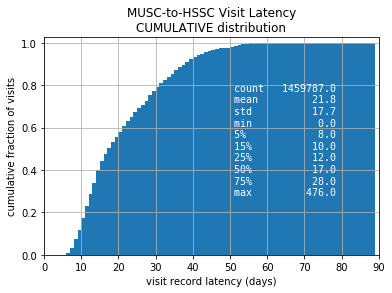

In [162]:
fig = latency.hist(bins=pd.np.arange(0,90,1), cumulative=True, density=1)
fig.set_xlabel('visit record latency (days)')
fig.set_ylabel('cumulative fraction of visits')
fig.set_title('MUSC-to-HSSC Visit Latency\nCUMULATIVE distribution')
with pd.option_context('float_format', '{:.1f}'.format):
    desc = latency[latency>=0].describe(percentiles=[0.05,0.15,0.25,0.50,0.75])
    plt.text(51, 0.28, desc.to_string(), color='white', family='monospace')
plt.ylim(0,1.025)
plt.xlim(0, 90)
plt.savefig('visit_latency_MUSC_to_HSSC.png', bbox_inches='tight')
# plt.show()

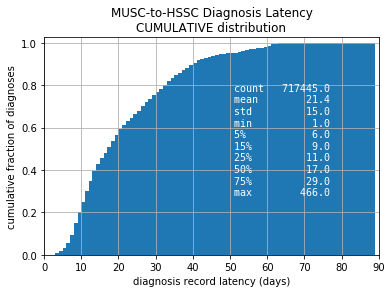

In [172]:
fig = latency_d.hist(bins=pd.np.arange(0,90,1), cumulative=True, density=1)
fig.set_xlabel('diagnosis record latency (days)')
fig.set_ylabel('cumulative fraction of diagnoses')
fig.set_title('MUSC-to-HSSC Diagnosis Latency\nCUMULATIVE distribution')
with pd.option_context('float_format', '{:.1f}'.format):
    desc = latency_d[latency_d>=0].describe(percentiles=[0.05,0.15,0.25,0.50,0.75])
    plt.text(51, 0.28, desc.to_string(), color='white', family='monospace')
plt.ylim(0,1.025)
plt.xlim(0, 90)
plt.savefig('diagnosis_latency_MUSC_to_HSSC.png', bbox_inches='tight')
# plt.show()

In [168]:
print(sum(df_v1s.htb_enc_act_id.isin(df_v1s_d.htb_enc_act_id))/len(df_v1s))
print(sum(df_v1s_d.htb_enc_act_id.isin(df_v1s.htb_enc_act_id))/len(df_v1s_d))

0.4656011190236765
0.9850762079323153


In [170]:
df_encs_dxs = df_v1s_d.merge(df_v1s, on='htb_enc_act_id')

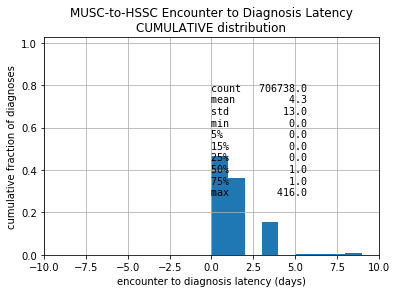

In [179]:
fig = latency_enc2dx.hist(bins=pd.np.arange(-10,10,1), density=1)
fig.set_xlabel('encounter to diagnosis latency (days)')
fig.set_ylabel('cumulative fraction of diagnoses')
fig.set_title('MUSC-to-HSSC Encounter to Diagnosis Latency\nCUMULATIVE distribution')
with pd.option_context('float_format', '{:.1f}'.format):
    desc = latency_enc2dx.describe(percentiles=[0.05,0.15,0.25,0.50,0.75])
    plt.text(0, 0.28, desc.to_string(), color='k', family='monospace')
plt.ylim(0,1.025)
plt.xlim(-10, 10)
# plt.savefig('dx2enc_latency_MUSC_to_HSSC.png', bbox_inches='tight')
plt.show()

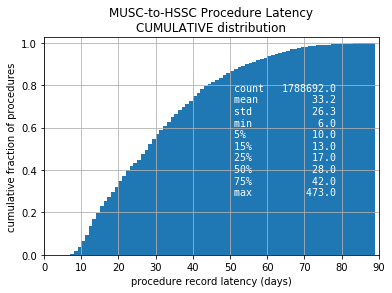

In [163]:
fig = latency_p.hist(bins=pd.np.arange(0,90,1), cumulative=True, density=1)
fig.set_xlabel('procedure record latency (days)')
fig.set_ylabel('cumulative fraction of procedures')
fig.set_title('MUSC-to-HSSC Procedure Latency\nCUMULATIVE distribution')
with pd.option_context('float_format', '{:.1f}'.format):
    desc = latency_p[latency_p>=0].describe(percentiles=[0.05,0.15,0.25,0.50,0.75])
    plt.text(51, 0.28, desc.to_string(), color='white', family='monospace')
plt.ylim(0,1.025)
plt.xlim(0, 90)
plt.savefig('procedure_latency_MUSC_to_HSSC.png', bbox_inches='tight')
# plt.show()

In [47]:
df_cdw_vnums.head()

htb_enc_id_ext  htb_enc_act_id  htb_enc_act_ver_num    visit_start_date  \
0     1113558789    335116976501                    1 2017-11-14 09:53:00   
1     1113558949    335116976601                    1 2017-11-14 15:26:00   
2     1113558960    335116976701                    1 2017-11-14 13:16:00   
3     1113559029    335116976801                    1 2017-11-15 12:55:00   
4     1113559070    335116976901                    1 2017-11-13 10:53:00   

       visit_end_date    last_update_date  
0 2017-11-14 23:59:00 2017-12-11 11:09:44  
1 2017-11-14 23:59:00 2017-12-11 11:09:44  
2 2017-11-14 23:59:00 2017-12-15 16:59:50  
3                 NaT 2017-11-29 13:24:50  
4 2017-11-15 14:50:00 2017-12-11 11:09:44

In [48]:
df_cdw_vnums.htb_enc_act_ver_num.value_counts()

1    4918393
2          5
3          2
Name: htb_enc_act_ver_num, dtype: int64

In [53]:
import datetime

df_cdw_vnums_with_dates.admdt.head().apply(lambda x: datetime.datetime(x.year, x.month, 1))

In [57]:
df_cdw_vnums_with_dates['admdt_m'] = df_cdw_vnums_with_dates.admdt.apply(lambda x: datetime.datetime(x.year, x.month, 1))

TypeError: integer argument expected, got float